In [0]:
# Rory Smith (Monash University): BigDat 2019, Cambdirge, UK
import numpy as np
import pylab as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
from IPython.display import clear_output

set_matplotlib_formats('retina')
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick
import scipy 
from scipy.stats import norm, uniform
from matplotlib import rc
font = {'family' : 'sans serif',
        'weight': 'regular',
        'size'   : 20}

rc('font', **font)
#rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (0.4*8*1.9, 0.4*1.9*4*1.2)

# Lecture 2: high dimensional problems


* Scalability and high-dimensional models
    * The curse of dimensionality
* Parameter estimation for high-dimensional models
    * Posterior samples using MCMC
    * Uncertainty quantification 
* Hypothesis testing with high-dimension models
    * Using nested sampling to estimate the evidence and compute odds ratios

# A more complex example: Uncertain signal and unknown noise 

In [0]:

# "True" model parameters
m_true = -0.9594 # line slope of straight-line component
c_true = 4.3 # size of the power-law component
sigma_noise_true = 0.534 # std. dev. on noise (noise is Gaussian)
mu_noise_true = 9.5 # mean of noise (noise is Gaussian)

# Generate some synthetic data from the model.
N = 100 # number of data points
np.random.seed(100)
x = np.sort(10*np.random.rand(N)) # x-values (independent variable) 
np.random.seed(124)
noise = np.random.normal(loc=mu_noise_true, scale=sigma_noise_true, 
                         size=N)  

def line_model(x,m,c):
    
    y = m*x + c*x**0.4
    return y

y = line_model(x,m_true,c_true)
data = y + noise

data_dict = {}
data_dict['x'] = x
data_dict['y'] = data


Text(0,0.5,'y')

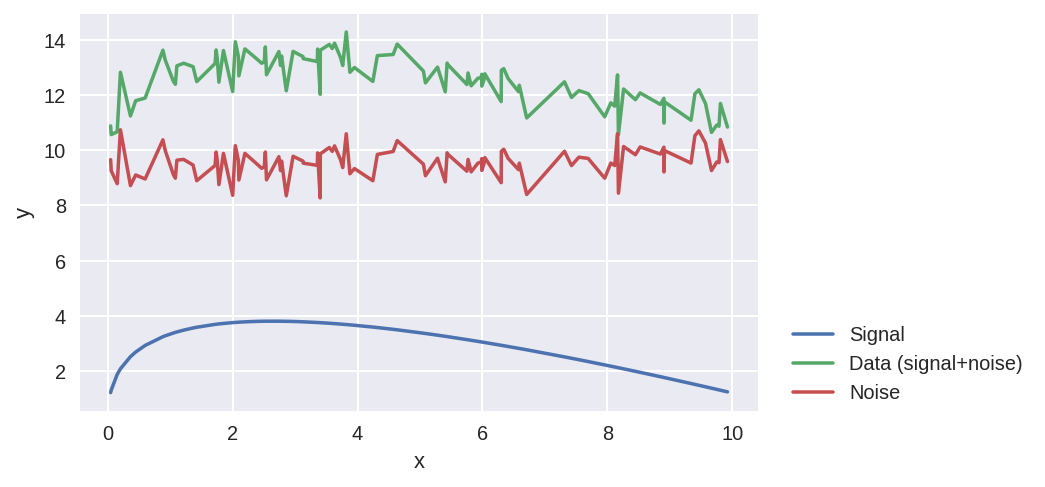

In [0]:
plt.plot(x,y,label='Signal')
plt.plot(x,data,label='Data (signal+noise)')
plt.plot(x,noise,label='Noise')
plt.legend(loc=(1.04,0))
plt.xlabel('x')
plt.ylabel('y')


## Our Description of the data 

Let's assume that we know that: $\textit(a)$ the noise is Gaussian distributed with unknown mean and variance, and $\textit(b)$ the data consists of a line plus noise, where the line has  unknown shape parameters. The model for our data can be summarized as:  



---
* $n(x_i) \sim \mathcal{N}(\mu,\sigma)\,\, \forall\,\, x_i$
* $y_{\text{signal}}(x_i;m, c) = mx_i + cx_i^{0.4}$ 
* $d(x_i) = y_{\text{signal}}(x_i;m,c) + n(x_i;\mu,\sigma)$


---


Our unkown (free) model parameters are

* The std. dev. of the noise $\sigma$
* The mean of the noise $\mu$
* The slope of the straight-line component $m$
* The size of the powerlaw component $c$

We'll collect the parameters into a single vector

$\theta = \{\sigma, \mu, m, c\}$




# Scalability in high-dimensional models


In Lecture 1, we only had two dimensions. We could grid up the 2D space, and evaluate the likelihood, prior, and hence posterior, exactly at the grid points. 

* This is the (un-normalized) posterior PDF 


<img src="https://docs.google.com/uc?export=download&id=1fbrCQsOTNfm8l9FxtwBochVkBY_kjbXM" width="400">


We could also compute the evidence numerically by performing a 2D integral over amplitude and frequency.

We hit a wall with grid-based methods as soon as $D$ is larger than about 3 or 4.

The total number of grid points ($N$) scales with the number of points in each dimension ($n$) of the parameter space like $N \sim O(n^D)$.

This is the $\textbf{curse of dimensionality}$. 
Just 10 grid points in each of ten independent dimensions gives $10^9$ points at which we would have to evaluate the posterior.

Many models are computationally slow to evaluate and such a large number of evaluations would be prohibitive.


## Sampling

A resolution to the curse of dimensionality is to realize that we don't really care about the full posterior: we often only need to know where the $\textit{bulk of the probability}$ is contained, and we can often ignore the extreme end of the tails of the distribution (think about a 1D Gaussian, for example). 

Sampling is a common theme. We have used in-built $\texttt{numpy}$ functions to draw samples from a Gaussian to generate the "noise" for our synthetic data sets. If we overplot the density of sample points with the true PDF, we can see that we're obtaining points with the correct probability:

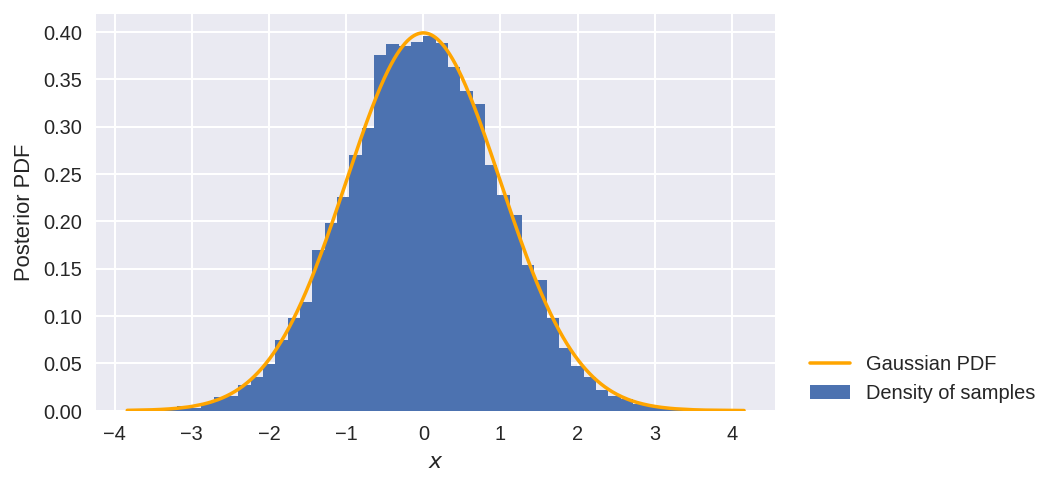

In [0]:
samples_from_normal = np.random.normal(size=10000)
sorted_samples = np.sort(samples_from_normal)
Gaussian_pdf = norm.pdf(sorted_samples)
plt.hist(samples_from_normal,density=True,bins=50,label='Density of samples')
plt.plot(sorted_samples, Gaussian_pdf, c='orange',label='Gaussian PDF')

plt.xlabel("$x$")
plt.ylabel("Posterior PDF")
plt.legend(loc=(1.04,0))


In-built functions like this typically use "Inverse CDF sampling" or "Inverse Transform Sampling". Briefly, the inverse transform sampling method hinges on our computer's ability to sample uniformly on the unit interval well. A sample can easily be drawn between [0,1] and then mapped onto a random variable using the CDF (cumulative distirbution function). For example, for the Poisson distribution:


<img src="https://docs.google.com/uc?export=download&id=1JV36YvvpnCvuQIKSVfH2pBEplmsJKpAQ" width="400">


This easily generates samples from 1D distributions where we can already construct the CDF. However, we don't know the PDF $\textit{or}$ CDF for general, data-driven distributions like the ones we have.

How do we sample a general posterior PDF? i.e., one that does not admit a neat, closed-form expression. There are many answeres to this question, but a widely-used solution is to turn to "Monte Carlo" sampling methods, such as $\textbf{Markov Chain Monte Carlo (MCMC)}$.

MCMC is typically used only to generate samples from the posterior: it is not well adapted to esimating the evidence, so isn't usually used to perform hypothesis testing. An algorithm called $\textbf{nested sampling}$ is designed specifically to estimate the evidence, but also produces posterior sampels as a byproduct. We'll look at nested sampling towards the end of the lecture.


# MCMC 

MCMC itself has many variants, but a commonly used one involves the "Metropolis Hastings Algorithm". See, e.g., [emcee: The MCMC Hammer](https://arxiv.org/abs/1202.3665)




The output of MCMC is an N-dimensional list which can be, e.g., histogrammed to form the probability density. We can also easily obtain the marginalized 1-D, 2-D, etc... distributions by histogramming specific columns of the list.

Without getting bogged down in details, let's look at how this works in practice by using a well road-tested, off-the-shelf MCMC package: $\texttt{emcee}$. Our goal here is to use $\texttt{emcee}$ like we would call something like $\texttt{numpy.random.normal()}$. Once we have run the algorithm, we'll inspect the output and results to build intuition for high-dimensional samples.

## MCMC example: Exploring the posterior distribution of the signal $\textit{and}$ noise parameters

### Our objective

We wish to obtain samples $\{\theta\}$ drawn from the posterior distribution $p(\theta | d, \mathcal{H}_S) $-- analagous to x in the histogram above -- where $\mathcal{H}_S$, and the data $d$ are defined in the code snippet at the start of the notebook.

* Each sample $\theta_i$ is a 4-dimensional tuple 
  * $\theta_i = (m_i, c_i, \mu_i, \sigma_i)$
  * The density of sample points should reflect the underlying probability density which we can't evaluate directly because of the "curse of dimensionality"
  
  An example from the output of this exercise is shown below:
  
  <img src="https://docs.google.com/uc?export=download&id=18n8zUVr1cMITJ8c9YVULv4Jauma-5mTJ" width="600">
  


## Defining the target probability distribution 

In the language of Bayesian inference, we can construct a posterior PDF on the parameters $\theta$ given our hypothesis $\mathcal{H}_S$ -- the data contain a signal :


---


$p(\theta | d, \mathcal{H}_S) = \frac{\pi(\theta)\mathcal{L}(d|\theta,\mathcal{H}_S)}{Z(d|\mathcal{H}_S)}$


---


The LHS is the four-dimensional posterior PDF. On the LHS are: 

* The Prior $\pi(\theta)$
* The Likelihood of the data under the signal hypothesis $\mathcal{L}(d|\theta,\mathcal{H}_S)$
* The Evidence that the data contain a signal $Z(d|\mathcal{H}_S)$

Our goal is to obtain samples from the posterior PDF. Recall that samples are just draws from a probability distribution. They can be, e.g., histogrammed to construct the probability density function. For instance, in 1D, we used $\texttt{numpy}$ function $\texttt{np.random.rand()}$ to generate $N$ random "noise" variables, distributed according to a normal distribution. If we histogram the noise, we should see that the density of points is the Gaussian PDF:

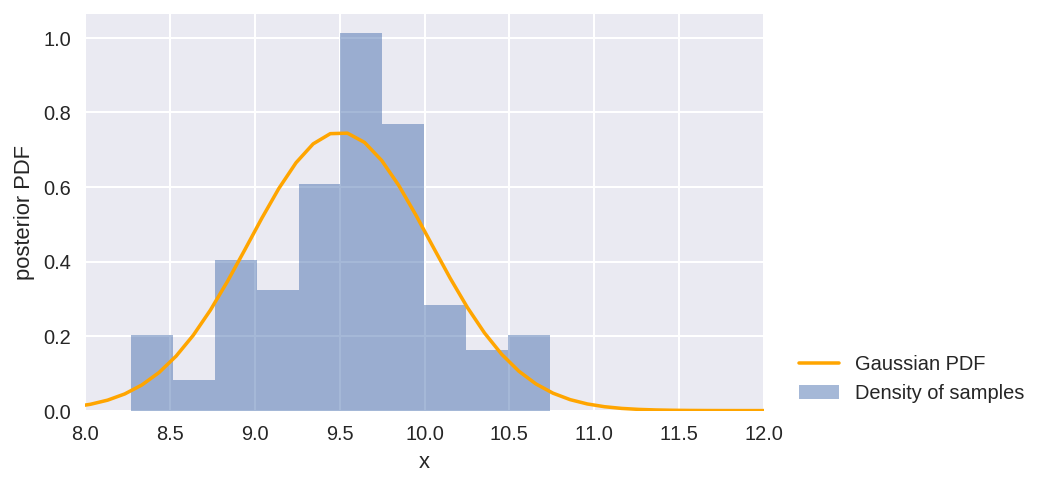

In [0]:
plt.hist(noise,density=True,alpha=0.5,label='Density of samples')
_x = np.linspace(5,15,100)
Gaussian_pdf = norm.pdf(_x,loc=mu_noise_true, scale=sigma_noise_true)
plt.plot(_x, Gaussian_pdf, c='orange',label='Gaussian PDF')
plt.xlim(8,12)
plt.xlabel("x")
plt.ylabel("posterior PDF")
plt.legend(loc=(1.04,0))

## Constructing the elements of the posterior

To evaluate the posterior, 

$p(\theta | d, \mathcal{H}_S) = \frac{\pi(\theta)\mathcal{L}(d|\theta,\mathcal{H}_S)}{Z(d|\mathcal{H}_S)}$

we will need to write down a prior 

$\pi(\theta)$

and a likelihood function. 

$\mathcal{L}(d|\theta,\mathcal{H}_S)$





### The prior

Starting with the prior, let's assume our usual uniform distribution on each of the four $\textit{a priori}$ unknown parameters bundled in $\theta$:


---


* $\pi(m) = \text{Uniform}(-2,2)$
* $\pi(c) = \text{Uniform}(2,20)$
* $\pi(\mu) = \text{Uniform}(6,12)$
* $\pi(\sigma) = \text{Uniform}(0.1,2)$


* $\pi(\theta) = \pi(m)\pi(c)\pi(\mu)\pi(\sigma)$


---


Outside of the ranges specified, the probabiltiy will assumed to be zero.

Note that the product of priors follows from the assumption that the parameters are independent/uncorrelated


In [0]:
m_min, m_max = -2, 2
c_min, c_max = 2, 20
mu_min, mu_max = 6, 12
sigma_min, sigma_max = 0.1, 2


def ln_prior(theta):
    
    m = theta[0]
    c = theta[1]
    mu = theta[2]
    sigma = theta[3]
    
    ln_pi_m = uniform.logpdf(m, loc=m_min, scale=m_max)
    ln_pi_c = uniform.logpdf(c, loc=c_min, scale=c_max)
    ln_pi_mu = uniform.logpdf(mu, loc=mu_min, scale=mu_max)
    ln_pi_sig = uniform.logpdf(sigma, loc=sigma_min, scale=sigma_max)
    
    ln_pi_theta = ln_pi_m + ln_pi_c + ln_pi_mu + ln_pi_sig
    
    return ln_pi_theta

### The likelihood

The three assuptions that form our model for the data are 


---


* $n(x_i;\mu,\sigma, m, c) \sim \mathcal{N}(\mu,\sigma)\,\, \forall\,\, x_i$
* $y_{\text{signal}}(x_i;m, c) = mx_i + cx_i^{0.4}$ 
* $d(x_i) = y_{\text{signal}}(x_i;m,c) + n(x_i;\mu,\sigma)$


---


Recall that in Lecture 1 we "rephrased" the signal hypothesis by leveraging our knowledge of the noise:

$\textbf{Signal Hypothesis: }\mathcal{H}_S $

* $n(x_i;\mu,\sigma) = d(x_i) - y_{\text{signal}}(x_i;m,c)$

with

* $n(x_i;\mu,\sigma) \sim \mathcal{N}(\mu,\sigma)\,\, \forall\,\, x_i$

This allowed us to write down the probability of the noise, given the data and the model. The likelihood of the residual $d(x_i) - y_{\text{signal}}(x_i;m,c)$ can be modelled as a Gaussian

* $\mathcal{L}(d|\theta,\mathcal{H}_S) = \prod_{i}\text{Normal}\Big([d_i - y_{\text{signal}}(m,c)_i], \mu, \sigma \Big)$

The product follows from the fact that each data sample $d_i = d(x_i)$ in the data set $d=\{d_1,d_2,...,d_N\}$ are \textit{iid} (indentically and independently distributed. 

Let's code this up. As we'll be working with reall small numbers, we'll do the usual thing of working with log probabilities.

* $\mathcal{L}(d|\theta,\mathcal{H}_S) = \prod_{i}\text{Normal}\Big([d_i - y_{\text{signal}}(m,c)_i], \mu, \sigma \Big)$

In [0]:
def ln_like(theta, data_dict, line_model):
    
    m = theta[0]
    c = theta[1]
    mu = theta[2]
    sigma = theta[3]
    
    x_data = data_dict['x']
    y_data = data_dict['y']
    
    sig = line_model(x_data,m,c)
    
    res = y_data-sig
    
    _lnL_d_i = norm.logpdf(res,loc=mu,scale=sigma)
    
    lnL = np.sum (_lnL_d_i)
    
    return lnL

### The (un-normalized) posterior

* $p(\theta | d, \mathcal{H}_S) \propto \pi(\theta)\mathcal{L}(d|\theta,\mathcal{H}_S)$

In [0]:

def ln_prob(theta, data_dict, line_model):
    
    m = theta[0]
    c = theta[1]
    mu = theta[2]
    sigma = theta[3]
    
    if m > m_max or m < m_min:
        ln_pi = -np.inf
    elif c > c_max or c < c_min:
        ln_pi = -np.inf
    elif mu > mu_max or mu < mu_min:
        ln_pi = -np.inf
    elif sigma > sigma_max or sigma < sigma_min:
        ln_pi = -np.inf
    else:
        ln_pi = ln_prior(theta)
    
    if ln_pi == -np.inf:
        return -np.inf
    
    else:
    
        lnL = ln_like(theta, data_dict, line_model)
    
        ln_prob = lnL + ln_pi
    
        return ln_prob

Notice that in the above, we haven't included the evidence term (which is a normalization). This will be fine if we just want to do parameter estimation. However, computing the evidence via sampling is a subject in its own right and can be obtained using "nested sampling" which we might look at if we have time.

For now, let's set up the mcmc sampler. We'll use the off-the-shelf package $\texttt{emcee}$


## MCMC with emcee: generating posterior samples

In [0]:
ndim, nwalkers = 4, 100
starts = [0,4,9,1]
pos = [starts + 1e-2*np.random.normal(size=ndim) for i in range(nwalkers)]

In [0]:

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, 
                                args=(data_dict, line_model))

In [0]:
sampler.run_mcmc(pos, 2000)

In [0]:
samples = sampler.chain[:, 1500:, :].reshape((-1, ndim))
print(samples.shape)

(50000, 4)


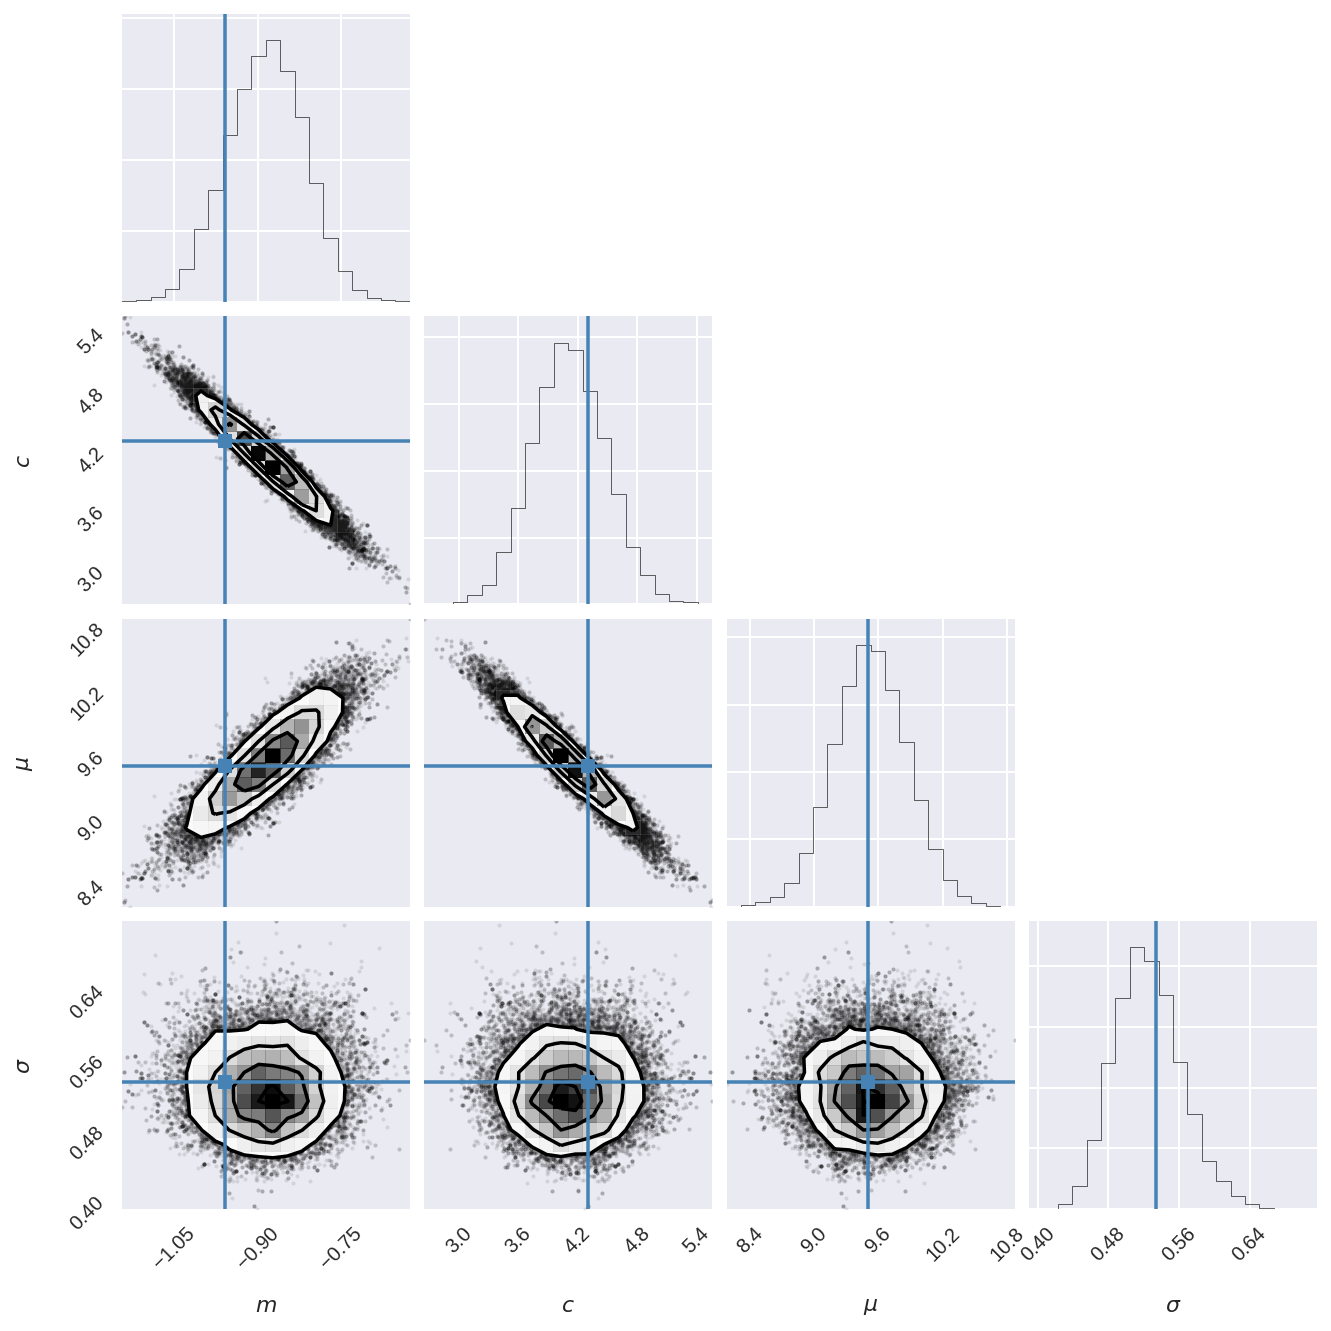

In [0]:
import corner
fig = corner.corner(samples, labels=["$m$", "$c$", "$\mu$","$\sigma$"],
                      truths=[m_true, c_true, mu_noise_true, 
                              sigma_noise_true])


We'll next look at two important concepts: $\textit{(a)}$ burnin, and $\textit{(b)}$ uncertainty quantification.



# Burnin

We threw away the first 1500 samples. Why? Let's look at the PDF if we had kept the first 1500:


In [0]:
samples_full = sampler.chain.reshape((-1, ndim))


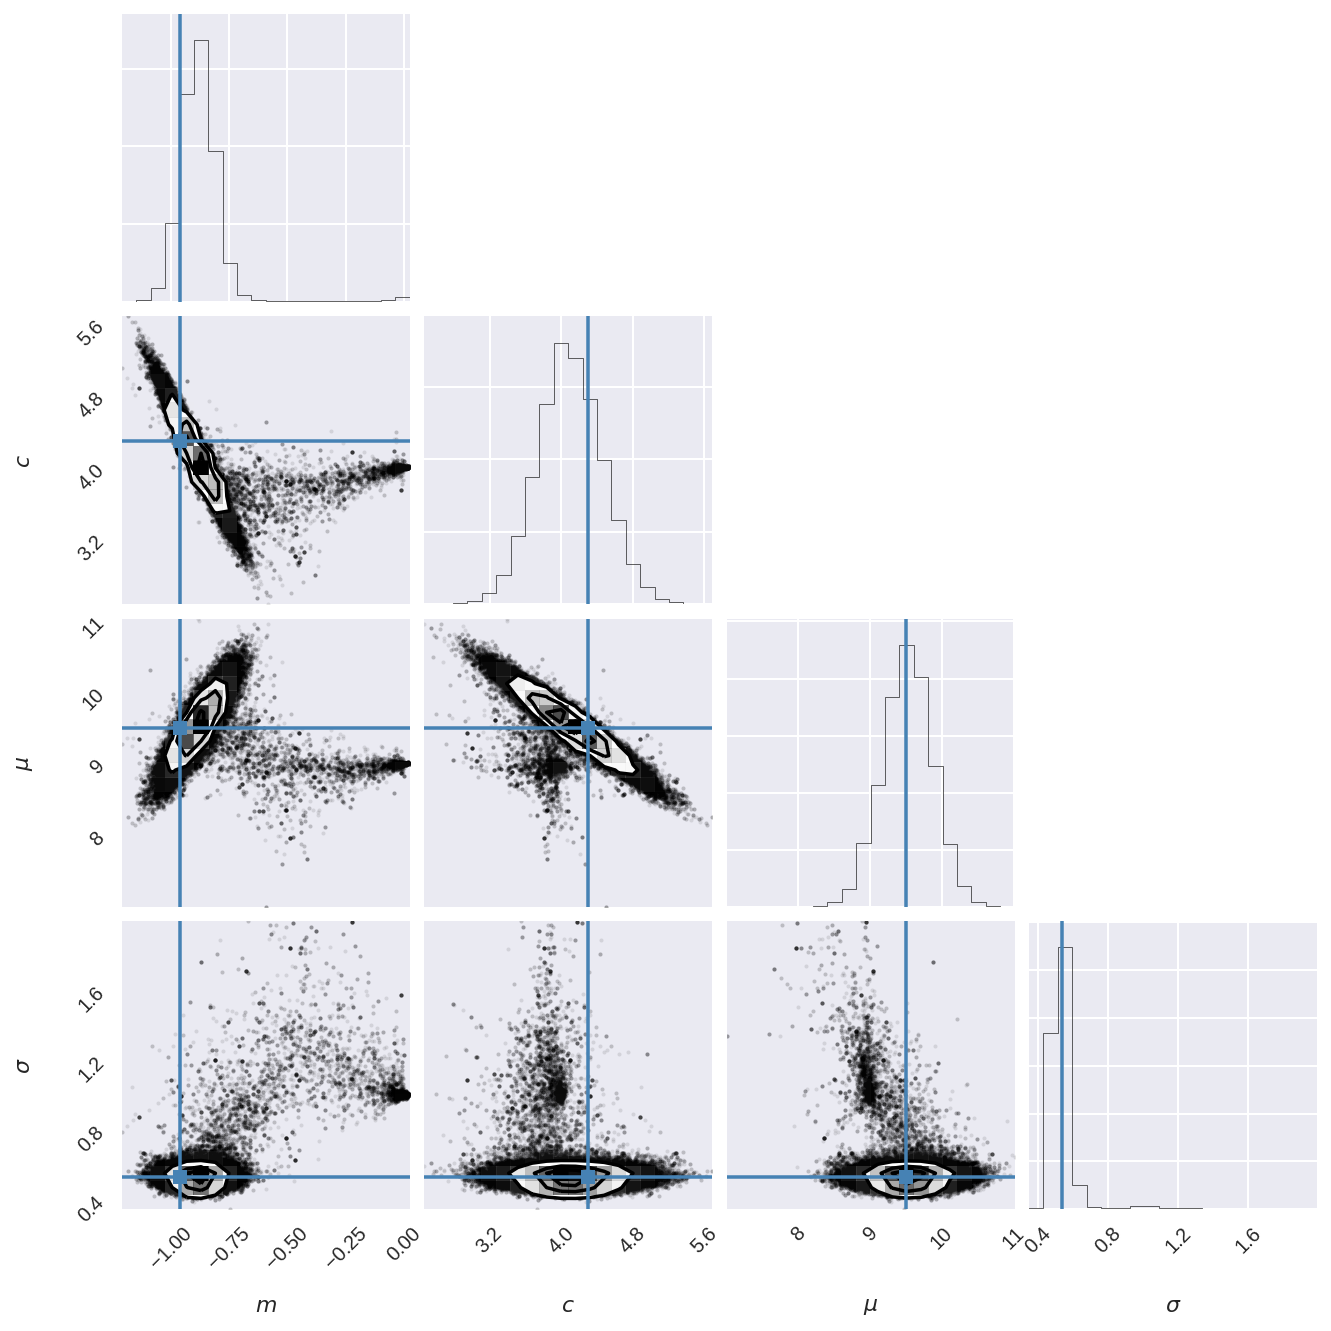

In [0]:
fig = corner.corner(samples_full, labels=["$m$", "$c$", "$\mu$","$\sigma$"],
                      truths=[m_true, c_true, mu_noise_true, sigma_noise_true])

MCMC has a property called "burnin": when we start out the sampler, the distribution of the initial points is totally different to the "true" distribution we're trying to sample. It takes some time for the algorithm to transition from the initial distribution of points to the true distribution of the underlying PDF. This is the "burnin" time. 

There are many rules of thumb and techniques to figure out when burnin has ended. However, in general it is hard to say quantitatively when burnin has ended. It involves finding the "steady state" distirbution of the sampler. For now, we'll just assume that the 1500 steps is a sufficiently large number for the sampler to have burned in and settled to the true distribution. 


# Uncertainty quantification 

In statistics, it is customary to summarize measurements in terms of "summary statistics". For instance, means, variances, skewness, etc...This is unnecessary, and often fails to capture subtleties in the underlying distributions. For example, it may be misleading to quote the mean and variance of a bimodal distribution, e.g.,

In [0]:
def bimodal():
    
    frac = 0.3
    samps = np.zeros(10000)
    
    for i in range(len(samps)):
    
        cointoss = np.random.uniform()
        if cointoss > frac:
            samps[i] = np.random.normal(loc=10,scale=4)
        else:
            samps[i] = np.random.normal(loc=0,scale=2)
            
    return samps



Text(0,0.5,'Posterior PDF')

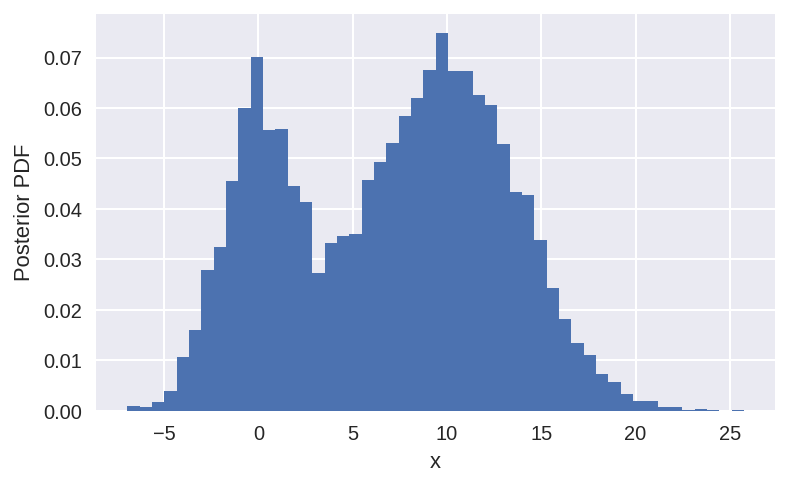

In [0]:
plt.hist(bimodal(), bins=50, density=True)
plt.xlabel("x")
plt.ylabel("Posterior PDF")

If our "measurement" consists of a posterior density function, we want to be able to describe as many features of the measurement as possible. Ideally, we shouldn't have to fall back on summary statistics that might only be applicable to simple distributions that don't represent our measurement well. However, it is usually customary to define a region of probability known as the "credible interval" (CI). The $X\%$ credible interval is the region about a point (e.g., the median) that contains $X\%$ of the probability. There are numerous ways to define such an interval, and it need not be symmetric. Usually, one picks a point, e.g., the median of the distribution, and integrates left and right until $X\%$ of the probability under the curve has been found. 

We can easily display these intevals using $\texttt{corner}$ in the following way. For instance, for the $90\%$ credible intervals

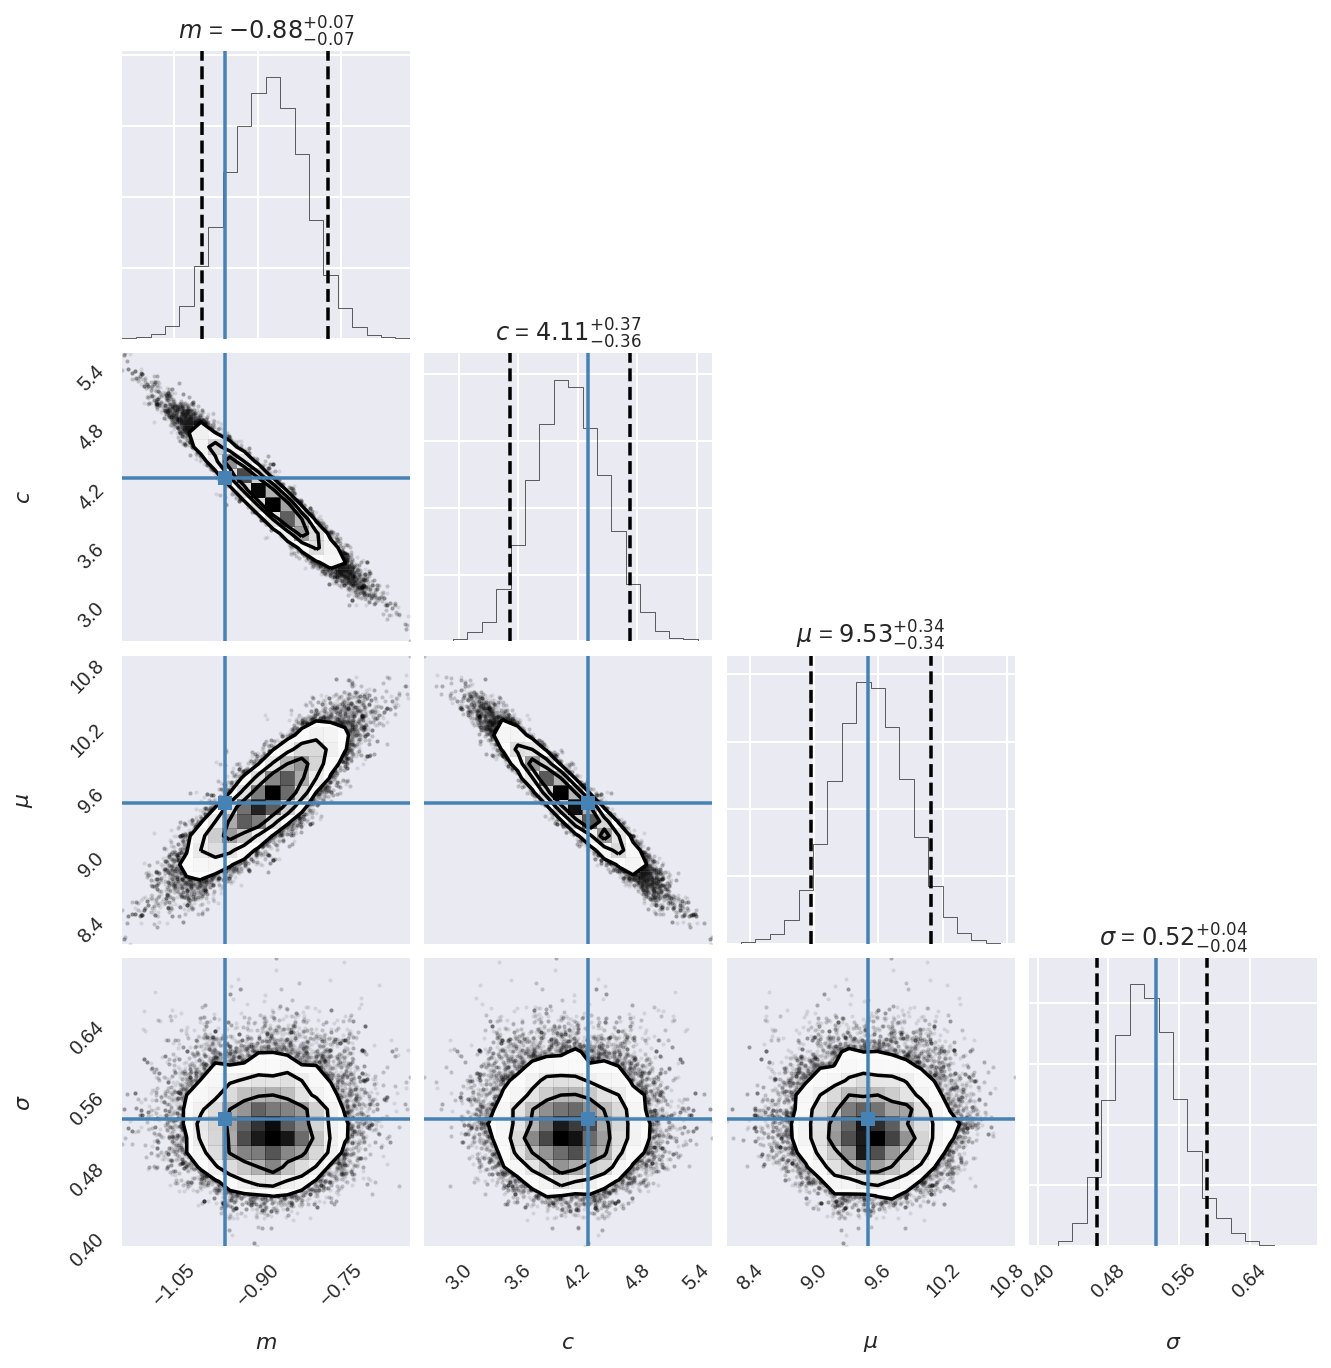

In [0]:
fig = corner.corner(samples, labels=["$m$", "$c$", "$\mu$","$\sigma$"],
                      truths=[m_true, c_true, mu_noise_true, 
                              sigma_noise_true],\
                   quantiles=[0.05,0.95], levels=[0.5,0.75,0.9],
                    show_titles=True)


We used the $\texttt{quantiles}=[0.05,0.95]$ argument to specify that we want to highlight the region in which $90\%$ of the probability is contained. The argument $\texttt{levels}=[0.5,0.75,0.9]$ produces the $50\%, 75\%$ and $90\%$ credible intervals on the 2D marginalized PDFs.  

The CI has a natural interpretation. If our likelihood is unbiased (meaning our signal and noise models are accurate) then we should expect the "true" parameter values to fall within the $X\%$ CI in exactly $X\%$ of the realizations of the data. Different noise realizations yield different PDFs.

# Mid Summary

* Sampled a posterior density using MCMC as implemented in the $\texttt{emcee}$ library
    * Explored uncertainty quantification of posterior PDFs via credible intervals
    
  

#  Estimating the Evidence and sampling the posterior with Nested Sampling

### Our objective



We have two hypotheses:

* (1) the data contain signal plus noise
* (2) the data contain just noise

we want to know

* $(a) \textbf{Which hypothesis is more probable and by how much?}$ 
* $(b) \textbf{What are the model parameters given each hypothesis?}$

The Odds Ratio compares the odds that the data are consistent with the signal or noise hypothesis. Recall that we have 

* $O_{S,N}=\frac{P(\mathcal{H}_S|I)}{P(\mathcal{H}_N|I)}\frac{Z(d|\mathcal{H}_S)}{Z(d|\mathcal{H}_N)}$

The posterior density tells us about the model parameters $\textit{under each hypothesis}$

* $p(\theta | d, \mathcal{H}_S) = \frac{\pi(\theta)\mathcal{L}(d|\theta,\mathcal{H}_S)}{Z(d|\mathcal{H}_S)}$


* $p(\theta | d, \mathcal{H}_N) = \frac{\pi(\theta)\mathcal{L}(d|\theta,\mathcal{H}_N)}{Z(d|\mathcal{H}_N)}$

The evidences in the odds ratio are just the "area under the posterior density", e.g.,

$Z(d|\mathcal{H}_S) = \int d\theta\, \pi(\theta) \mathcal{L}(d|\theta, \mathcal{H}_S)$

In order to evaluate the odds ratio, we need to compute the evidences

* These might involve multi-dimensional integrals that can be intractible because of the curse of dimensionality.

* Nested sampling overcomes the curse using sampling to estimate the evidence 

The rest of this lecture is devoted to the ultimate goal of computing the odds ratio: the single number that will tell us if we should believe our data contain a signal plus noise, or just noise. As a byproduct we will get the posterior samples as a bonus!

In order to do so, we will first introduce the idea of nested sampling. 

### Nested Sampling




The main idea behind nested sampling (Skilling 2006) is to find the "area under the curve". Recall that 

$\text{posterior} \times \text{evidence}$ = $\text{likelihood} \times \text{prior}$



The integral over the posterior is 1 (it's a normalized probability distribution) so the evidence is just the integral of the $\text{likelihood} \times \text{prior}$ over the parameter space.

Nested sampling is an algorithmic approach which works by finding nested contours of likelihood that enclose increasingly higher fractions of prior-probability. Once we have enclosed all of the prior probability, we should have found all of the area under the curve. 


<img src="https://docs.google.com/uc?export=download&id=1ZRrGY7JFFHEKRnYIqWAIGGTWGGMzT3dW" width="500">

Again, the exact details are not our main concern here, though I encourage you to read deeper into the details of the algorihtm. Here, we will look at a practical application and it suffices to know that there is an implementation which we can use to find the evideces for our data given various hypotheses. As before, we'll look at two cases: the signal hypothesis $\mathcal{H}_S$ and the noise hypothesis $\mathcal{H}_N$.



## Combined Parameter Estimation and Evidence Estimation with nested sampling

In [0]:
import dynesty



From the user's perspective, the packages $\texttt{emcee}$ and $\texttt{dynesty}$ work almost identically. Two exceptions are that $(i)$ $\texttt{dynesty}$ has stopping criterion based on the convergence of the evidence, and $(ii)$ $\texttt{dynesty}$ samples in "auxiliary variables" rather than the intrinsic parameters we care about. The latter point is more of a subtlety that's easy to overcome in practice. We won't dwell on this much, but briefly: $\texttt{dynesty}$ samples Uniformly on the N-dimensional unit hypercube. Samples from the hyper cube have to be mapped onto the real parameter space using a $\texttt{prior transform}$ function, shown below.

### The signal hypothesis

The signal hypothesis can be stated as follows:

* $\mathcal{H}_S : n(x_i;\mu,\sigma) = d(x_i) - y_{\text{signal}}(x_i;m,c)$

with
* $y_{\text{signal}}(x_i;m, c) = mx_i + cx_i^{0.4}$ 
* $n(x_i;\mu,\sigma) \sim \mathcal{N}(\mu,\sigma)\,\, \forall\,\, x_i$

We have two objectives:

1) Get samples from the posterior on $\theta=(m,c,\mu,\sigma)$:
* $P(\theta|d, \mathcal{H}_S)$

2) Compute the evidence of the data given the signal hypothesis :
* $\mathcal{Z}(d|\mathcal{H}_S)$



In [0]:
def prior_transform(utheta):
    
    um, uc, umu, usigma = utheta # these are samples from the unit hyper cube
    # the "prior transform" below maps the unit-cube samples to the 
    # parameters we care about 
    
    # Think of this as the result of performing the inverse CDF. The 
    #specific mapping here maps uniformly distributed samples 
    #(on the hypercube) to uniformly distributed samples
    # on the correct intervals
    
    m = (m_max - m_min) * um + m_min
    c = (c_max - c_min) * uc + c_min
    mu = (mu_max - mu_min) * umu + mu_min
    sigma = (sigma_max - sigma_min) * usigma + sigma_min
    
    return m, c, mu, sigma

def ln_like_for_nest(theta):
    
    m = theta[0]
    c = theta[1]
    mu = theta[2]
    sigma = theta[3]

    x_data = data_dict['x']
    y_data = data_dict['y']
    
    sig = line_model(x_data,m,c)
    
    res = y_data-sig
    
    _lnL_d_i = norm.logpdf(res,loc=mu,scale=sigma)
    
    lnL = np.sum (_lnL_d_i)
    
    return lnL

In [0]:
dsampler = dynesty.NestedSampler(ln_like_for_nest, prior_transform, ndim=4,
                                        nlive=1000)
dsampler.run_nested(dlogz=0.1)
dres = dsampler.results

iter: 19175+1000 | bound: 54 | nc: 1 | ncall: 78696 | eff(%): 25.637 | loglstar:   -inf < -74.598 <    inf | logz: -89.154 +/-  0.112 | dlogz:  0.000 >  0.010            

In [0]:
from dynesty import plotting as dyplot


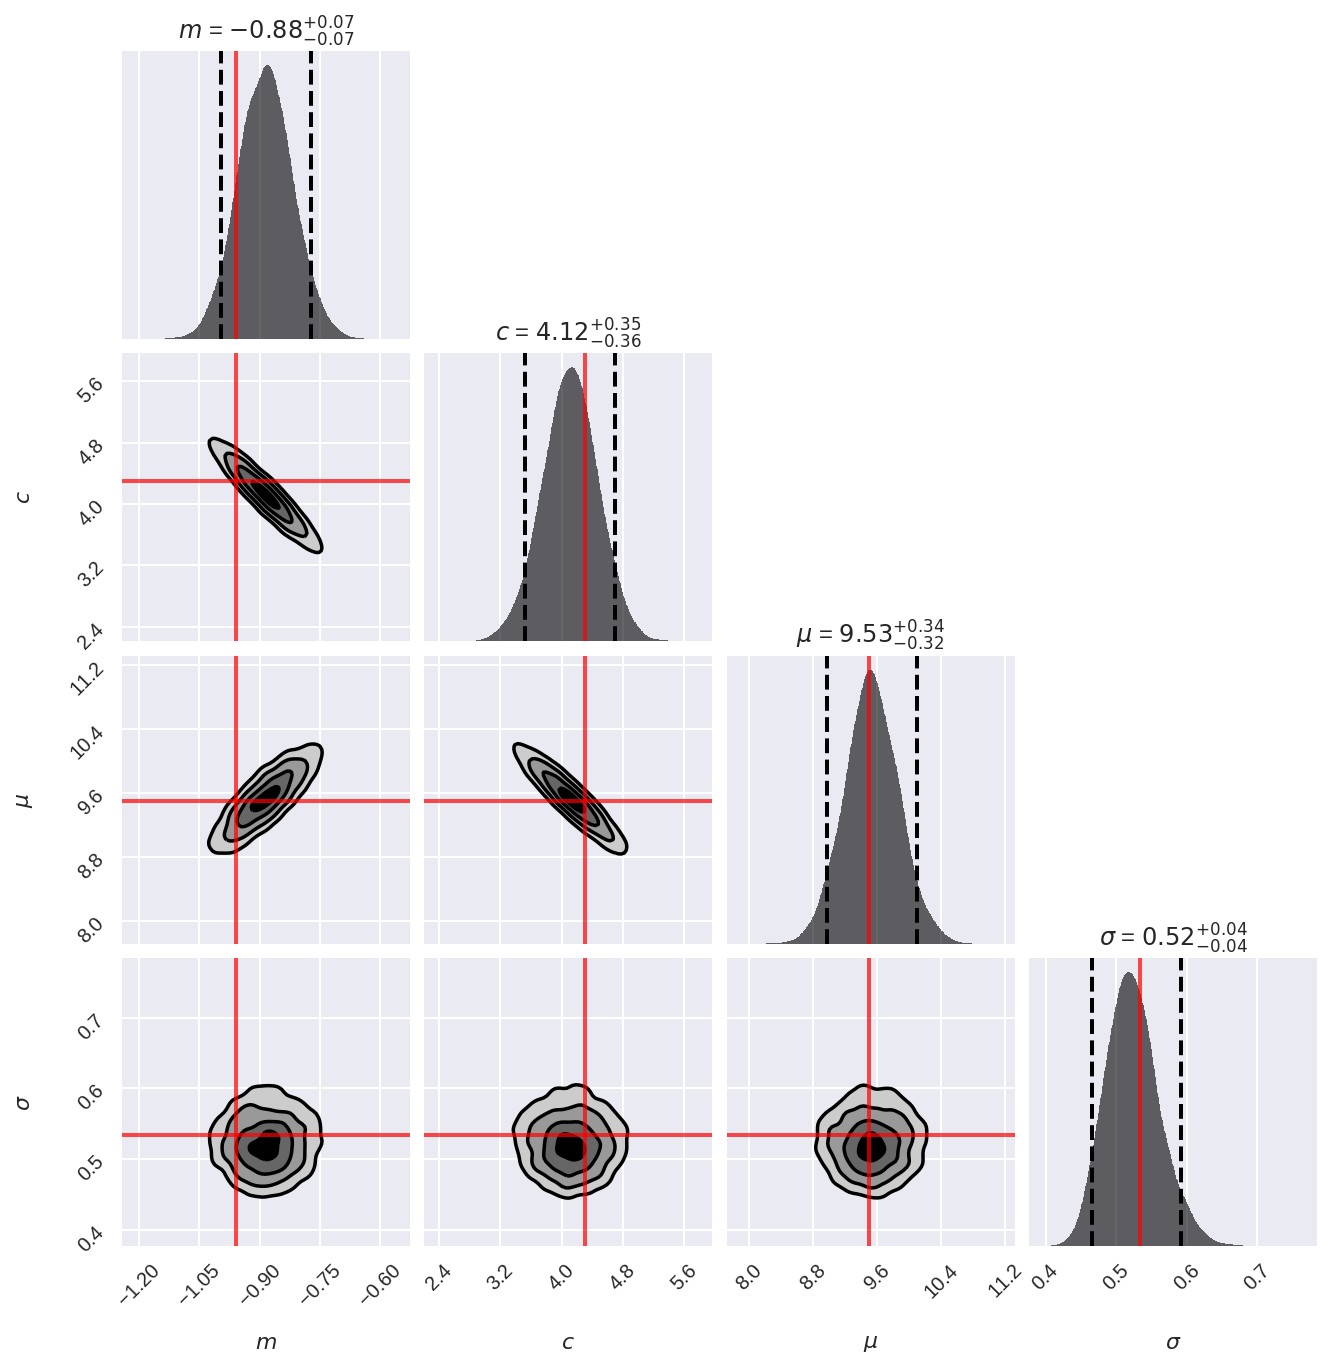

In [0]:
labels=[r"$m$", r"$c$", r"$\mu$",r"$\sigma$"]
truths=[m_true, c_true, mu_noise_true, sigma_noise_true]

fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
                             labels=labels,quantiles=[0.05,0.95])

In [0]:
logz_signal_hypothesis = dres['logz'][-1]
print (logz_signal_hypothesis)


-89.15398136670453


The (log) signal-evidence is 

* $\ln Z(d|\mathcal{H}_S) = -88.9$

### The Noise Hypothesis


In Lecture 1 we had a simple parameter-free noise hypothesis. Now, our noise hypothesis involves two $\textit{a priori}$ unknown parameters: $\mu$ and $\sigma$.

Our noise hypothesis now would be 

* $\mathcal{H}_N : d(x_i) = n(x_i;\mu,\sigma)$

with

* $n(x_i;\mu,\sigma) \sim \mathcal{N}(\mu,\sigma)\,\, \forall\,\, x_i$

As before we also have two objectives 

1) Obtain samples from the posterior on $\theta=(\mu,\sigma)$:
* $P(\theta|d, \mathcal{H}_N)$

2) The evidence of the data given the signal hypothesis :
* $\mathcal{Z}(d|\mathcal{H}_N)$

Let's code up a prior and likelihood function to sample $\mu$ and $\sigma$. We'll use nested sampling to get the posterior samples and the evidence.

In [0]:


def prior_transform_noise_only(utheta):
    
    umu, usigma = utheta # these are samples from the unit hyper cube
    # the "prior transform" below maps the unit-cube samples to the 
    # parameters we care about 
    
    # Think of this as the result of performing the inverse CDF. The 
    # specific mapping here
    # maps uniformly distributed samples (on the hypercube) to uniformly 
    #distributed samples on the correct intervals

    mu = (mu_max - mu_min) * umu + mu_min
    sigma = (sigma_max - sigma_min) * usigma + sigma_min
    
    return mu, sigma

def ln_like_for_nest_noise_only(theta):
    
    mu = theta[0]
    sigma = theta[1]

    x_data = data_dict['x']
    y_data = data_dict['y']

    _lnL_d_i = norm.logpdf(y_data,loc=mu,scale=sigma)
    
    lnL = np.sum (_lnL_d_i)
    
    return lnL

In [0]:
dsampler = dynesty.NestedSampler(ln_like_for_nest_noise_only, 
                                 prior_transform_noise_only, 
                                        ndim=2, nlive=1000)
dsampler.run_nested(dlogz=0.01)
dres = dsampler.results

iter: 12609+1000 | bound: 34 | nc: 1 | ncall: 63355 | eff(%): 21.481 | loglstar:   -inf < -145.942 <    inf | logz: -153.934 +/-  0.081 | dlogz:  0.000 >  0.010            

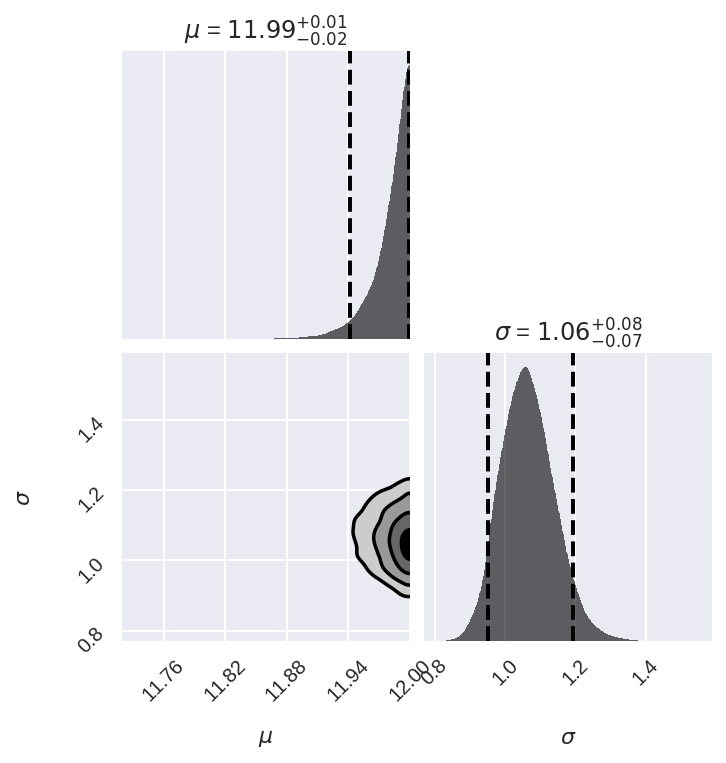

In [0]:
labels=[r"$\mu$",r"$\sigma$"]
truths=[mu_noise_true, sigma_noise_true]

fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
                             labels=labels,quantiles=[0.05,0.95])

Notice that the inferred parameters are heavily biased! This should be revealed in the Odds ratio. Let's look at the evidences for the signal and noise hypotheses 

In [0]:
logz_noise_hypothesis = dres['logz'][-1]
print (logz_noise_hypothesis)

-153.9340805611839


The (log) noise-evidence is 

* $\ln Z(d|\mathcal{H}_N) = -154$

## Hypothesis testing: signal or noise?


The Odds Ratio compares the odds that the data are consistent with the signal or noise hypothesis. Recall that we have 

* $O_{S,N}=\frac{P(\mathcal{H}_S|I)}{P(\mathcal{H}_N|I)}\frac{Z(d|\mathcal{H}_S)}{Z(d|\mathcal{H}_N)}$


Let's assume that we have equal prior odds for the signal and noise hypotheses so that:

* $P(\mathcal{H}_S|I) = P(\mathcal{H}_N|I)$

The Odds ratio is then just a ratio of the evidences we just computed:

* $O_{S,N}=\frac{Z(d|\mathcal{H}_S)}{Z(d|\mathcal{H}_N)}$

Inserting the values we just computed:

* $\ln Z(d|\mathcal{H}_S) = -88.9$
* $\ln Z(d|\mathcal{H}_N) = -154$

Giving 

* $\ln O_{S,N}= -88.9 - (-154) = 65.1$


And we find that we overwhelmingly favor the signal hypothesis over the noise hypothesis! 

# Summary

* Used MCMC to perform $\textit{parameter estimation}$ 
    * But not hypothesis testing
* Implemented nested sampling to:
    * Estimate evidences
    * Compute Odds ratios
    * Perform hypothesis testing

# Suggested topics for futher reading

## Sampling methods 

* Hamiltonian MCMC
    * Physics-inspired sampling techniques that can be more efficient at exploring the parameter space, e.g., STAN https://mc-stan.org/
    

## Approximate methods 



* Variational Bayes
    * Optimization based on variational methods. Gives a lower bound on evidences, e.g., Edward http://edwardlib.org/

## Probabilistic programing

e.g., Edward http://edwardlib.org/